# Inspect the single-lineage model run on the prostate data (004)

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)
- target gene mutation variable and cancer gene comutation variable.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

In [5]:
saved_model_dir = models_dir() / "hnb-single-lineage-prostate-004_PYMC_NUMPYRO"

In [6]:
with open(saved_model_dir / "description.txt") as f:
    model_description = "".join(list(f))

print(model_description)

name: 'hnb-single-lineage-prostate-004'
fit method: 'PYMC_NUMPYRO'

--------------------------------------------------------------------------------

CONFIGURATION

{
    "name": "hnb-single-lineage-prostate-004",
    "description": " Single lineage hierarchical negative binomial model for prostate data from the Broad. This model modifies 003 by changing the priors on the standard deviation variables from Gammas to HalfNormals so that they include 0. A step size is also supplied to help with NUTS tuning the HMC sampler. ",
    "active": true,
    "model": "LINEAGE_HIERARCHICAL_NB",
    "data_file": "modeling_data/lineage-modeling-data/depmap-modeling-data_prostate.csv",
    "model_kwargs": {
        "lineage": "prostate"
    },
    "sampling_kwargs": {
        "pymc_mcmc": null,
        "pymc_advi": null,
        "pymc_numpyro": {
            "draws": 1000,
            "tune": 1000,
            "chains": 4,
            "target_accept": 0.98,
            "progress_bar": true,
          

### Load posterior summary

In [7]:
prostate_post_summary = pd.read_csv(saved_model_dir / "posterior-summary.csv").assign(
    var_name=lambda d: [x.split("[")[0] for x in d["parameter"]]
)
prostate_post_summary.head()

parameter    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a   0.100  0.002     0.097      0.103      0.000    0.000    2050.0   
1      mu_b  -0.001  0.001    -0.002      0.000      0.000    0.000    4529.0   
2      mu_d  -0.020  0.001    -0.021     -0.019      0.000    0.000    4634.0   
3   sigma_a   0.211  0.001     0.210      0.213      0.000    0.000    1459.0   
4     alpha  12.489  0.039    12.429     12.552      0.001    0.001    2016.0   

   ess_tail  r_hat var_name  
0    2616.0    1.0  mu_mu_a  
1    3029.0    1.0     mu_b  
2    3443.0    1.0     mu_d  
3    2311.0    1.0  sigma_a  
4    2984.0    1.0    alpha

### Load trace object

In [8]:
trace_file = saved_model_dir / "posterior.netcdf"
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [9]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [10]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [11]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [12]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/29/22 15:57:36] INFO     Processing data for modeling.     ]8;id=417488;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=485849;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=640458;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=22371;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#270\270]8;;\

[07/29/22 15:58:41] WARNING  number of data points dropped: 2  ]8;id=419579;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=979450;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#321\321]8;;\

                    INFO     number of genes mutated in all    ]8;id=560756;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=489638;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#478\478]8;;\
                             cells lines: 0                                                  

                    INFO     Dropping 8 cancer genes.          ]8;id=867646;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=541487;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#534\534]8;;\

## Analysis

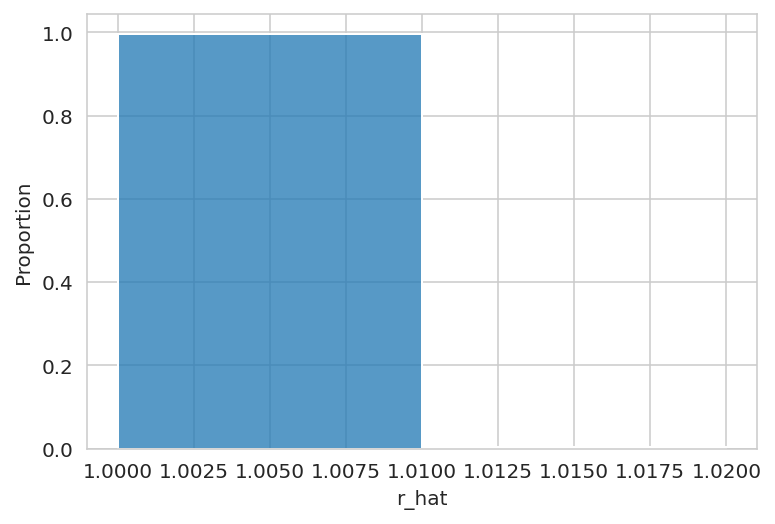

In [13]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

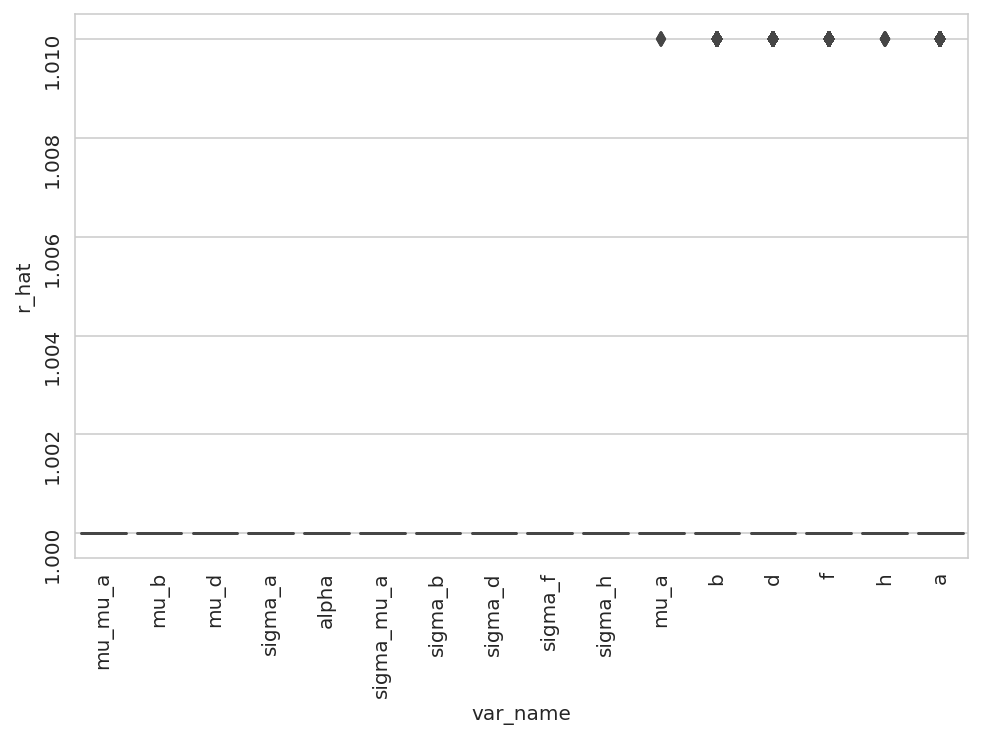

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

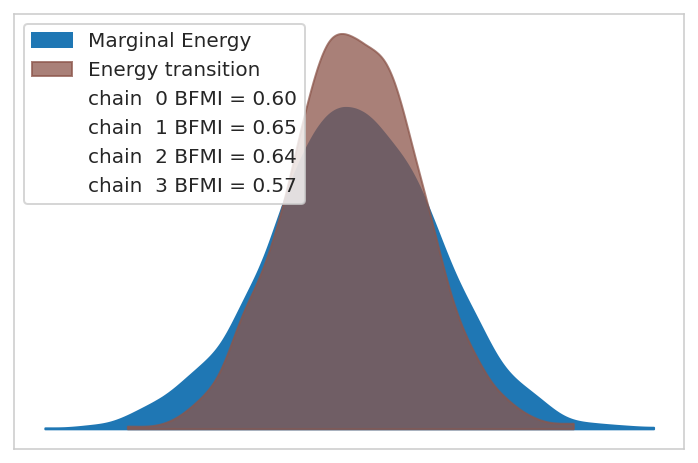

In [15]:
az.plot_energy(trace);

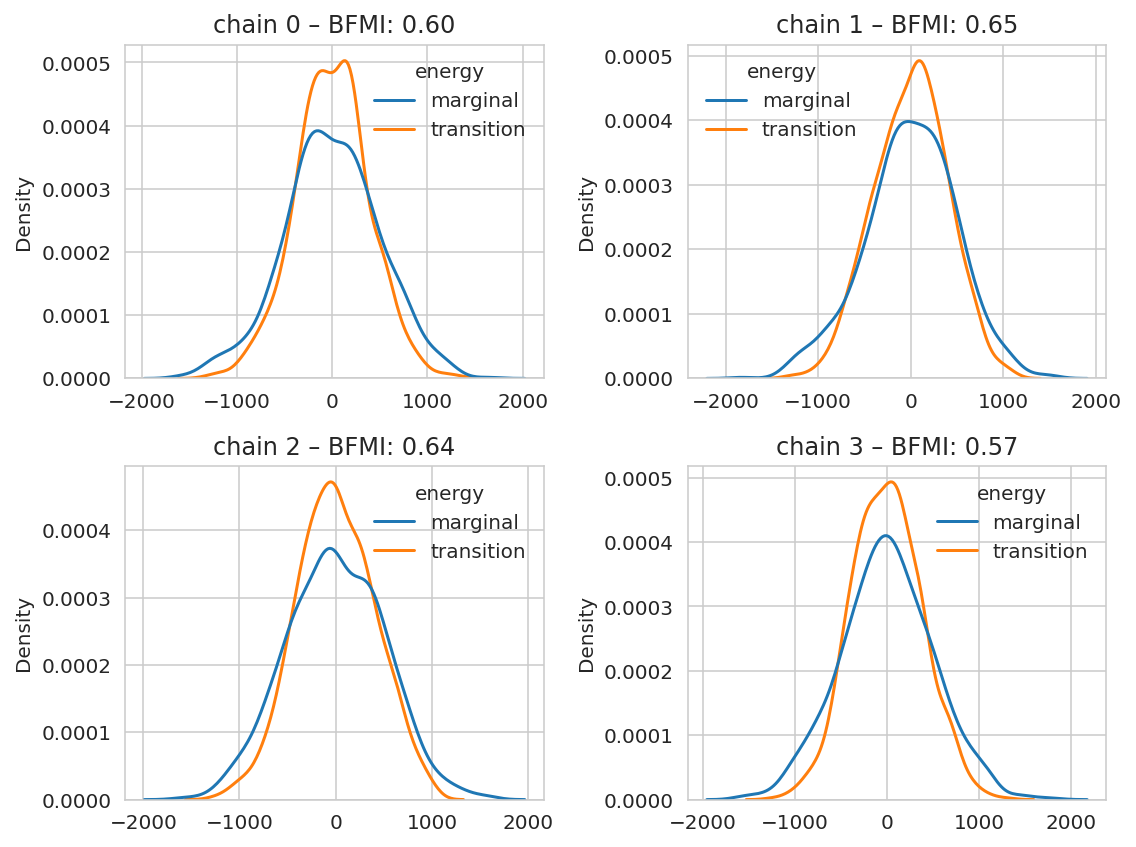

In [16]:
energy = trace.sample_stats.energy.values
marginal_e = pd.DataFrame((energy - energy.mean(axis=1)[:, None]).T).assign(
    energy="marginal"
)
transition_e = pd.DataFrame((energy[:, :-1] - energy[:, 1:]).T).assign(
    energy="transition"
)
energy_df = pd.concat([marginal_e, transition_e]).reset_index(drop=True)
bfmi = az.bfmi(trace)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for i, ax in enumerate(axes.flatten()):
    sns.kdeplot(data=energy_df, x=i, hue="energy", ax=ax)
    ax.set_title(f"chain {i} – BFMI: {bfmi[i]:0.2f}")
    ax.set_xlabel(None)
    xmin, _ = ax.get_xlim()
    _, ymax = ax.get_ylim()
    ax.get_legend().set_frame_on(False)

fig.tight_layout()
plt.show()

In [17]:
stats = ["step_size", "n_steps", "tree_depth", "acceptance_rate", "energy"]
trace.sample_stats.get(stats).to_dataframe().groupby("chain").mean()

step_size  n_steps  tree_depth  acceptance_rate        energy
chain                                                               
0       0.018534    255.0         8.0         0.978422  2.452655e+06
1       0.018075    255.0         8.0         0.978889  2.452672e+06
2       0.018088    255.0         8.0         0.978884  2.452727e+06
3       0.020123    255.0         8.0         0.972362  2.452692e+06

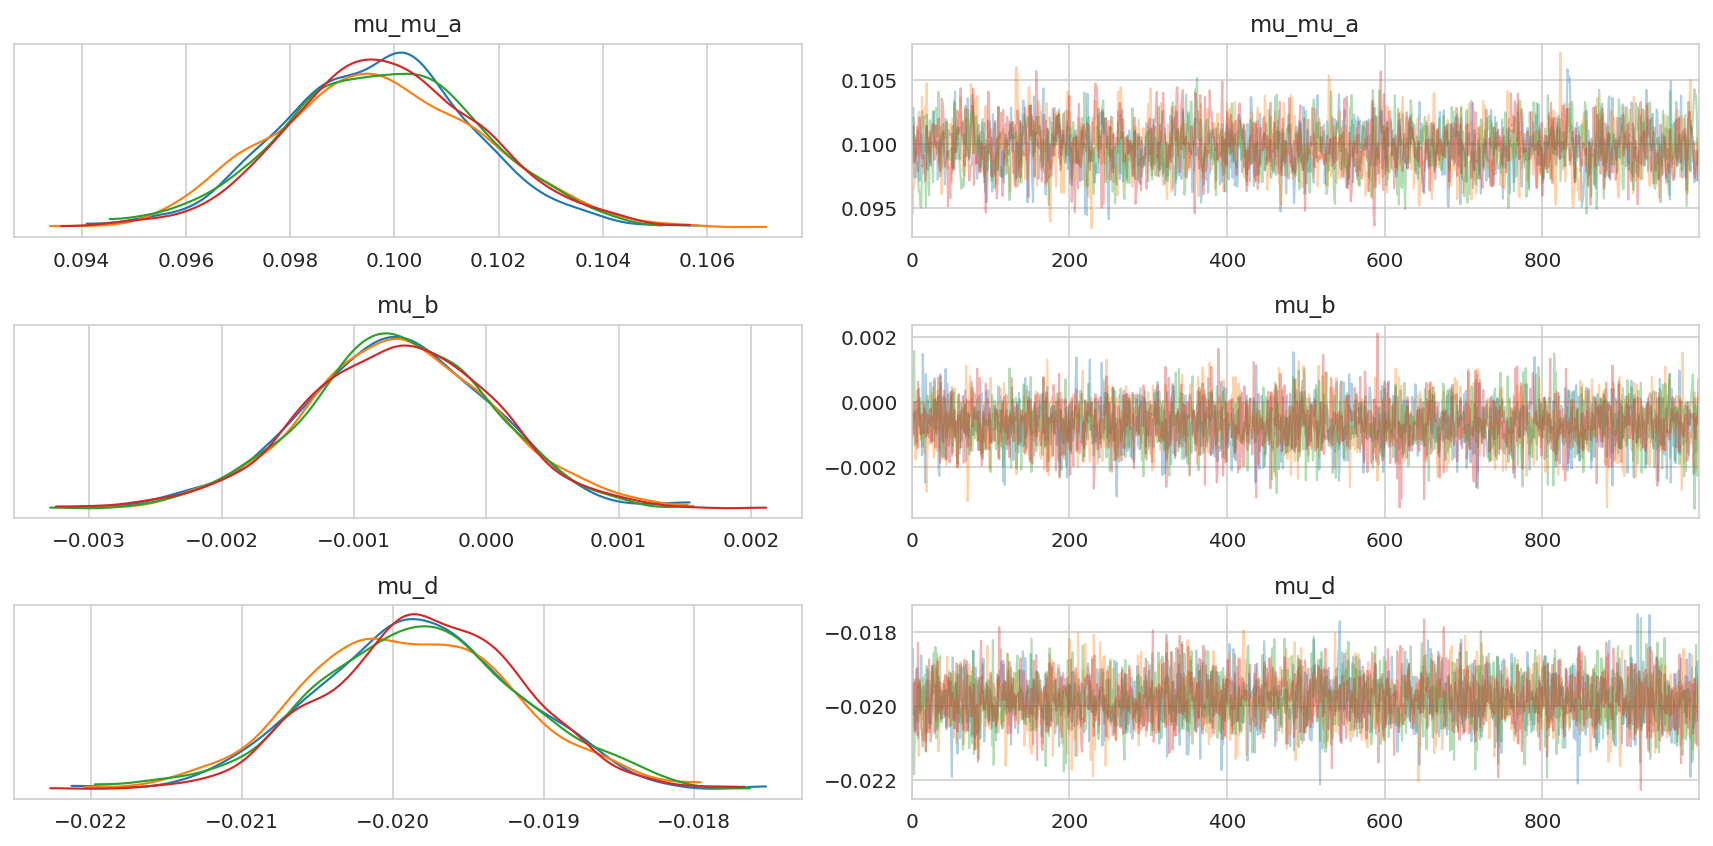

In [18]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
plt.tight_layout()

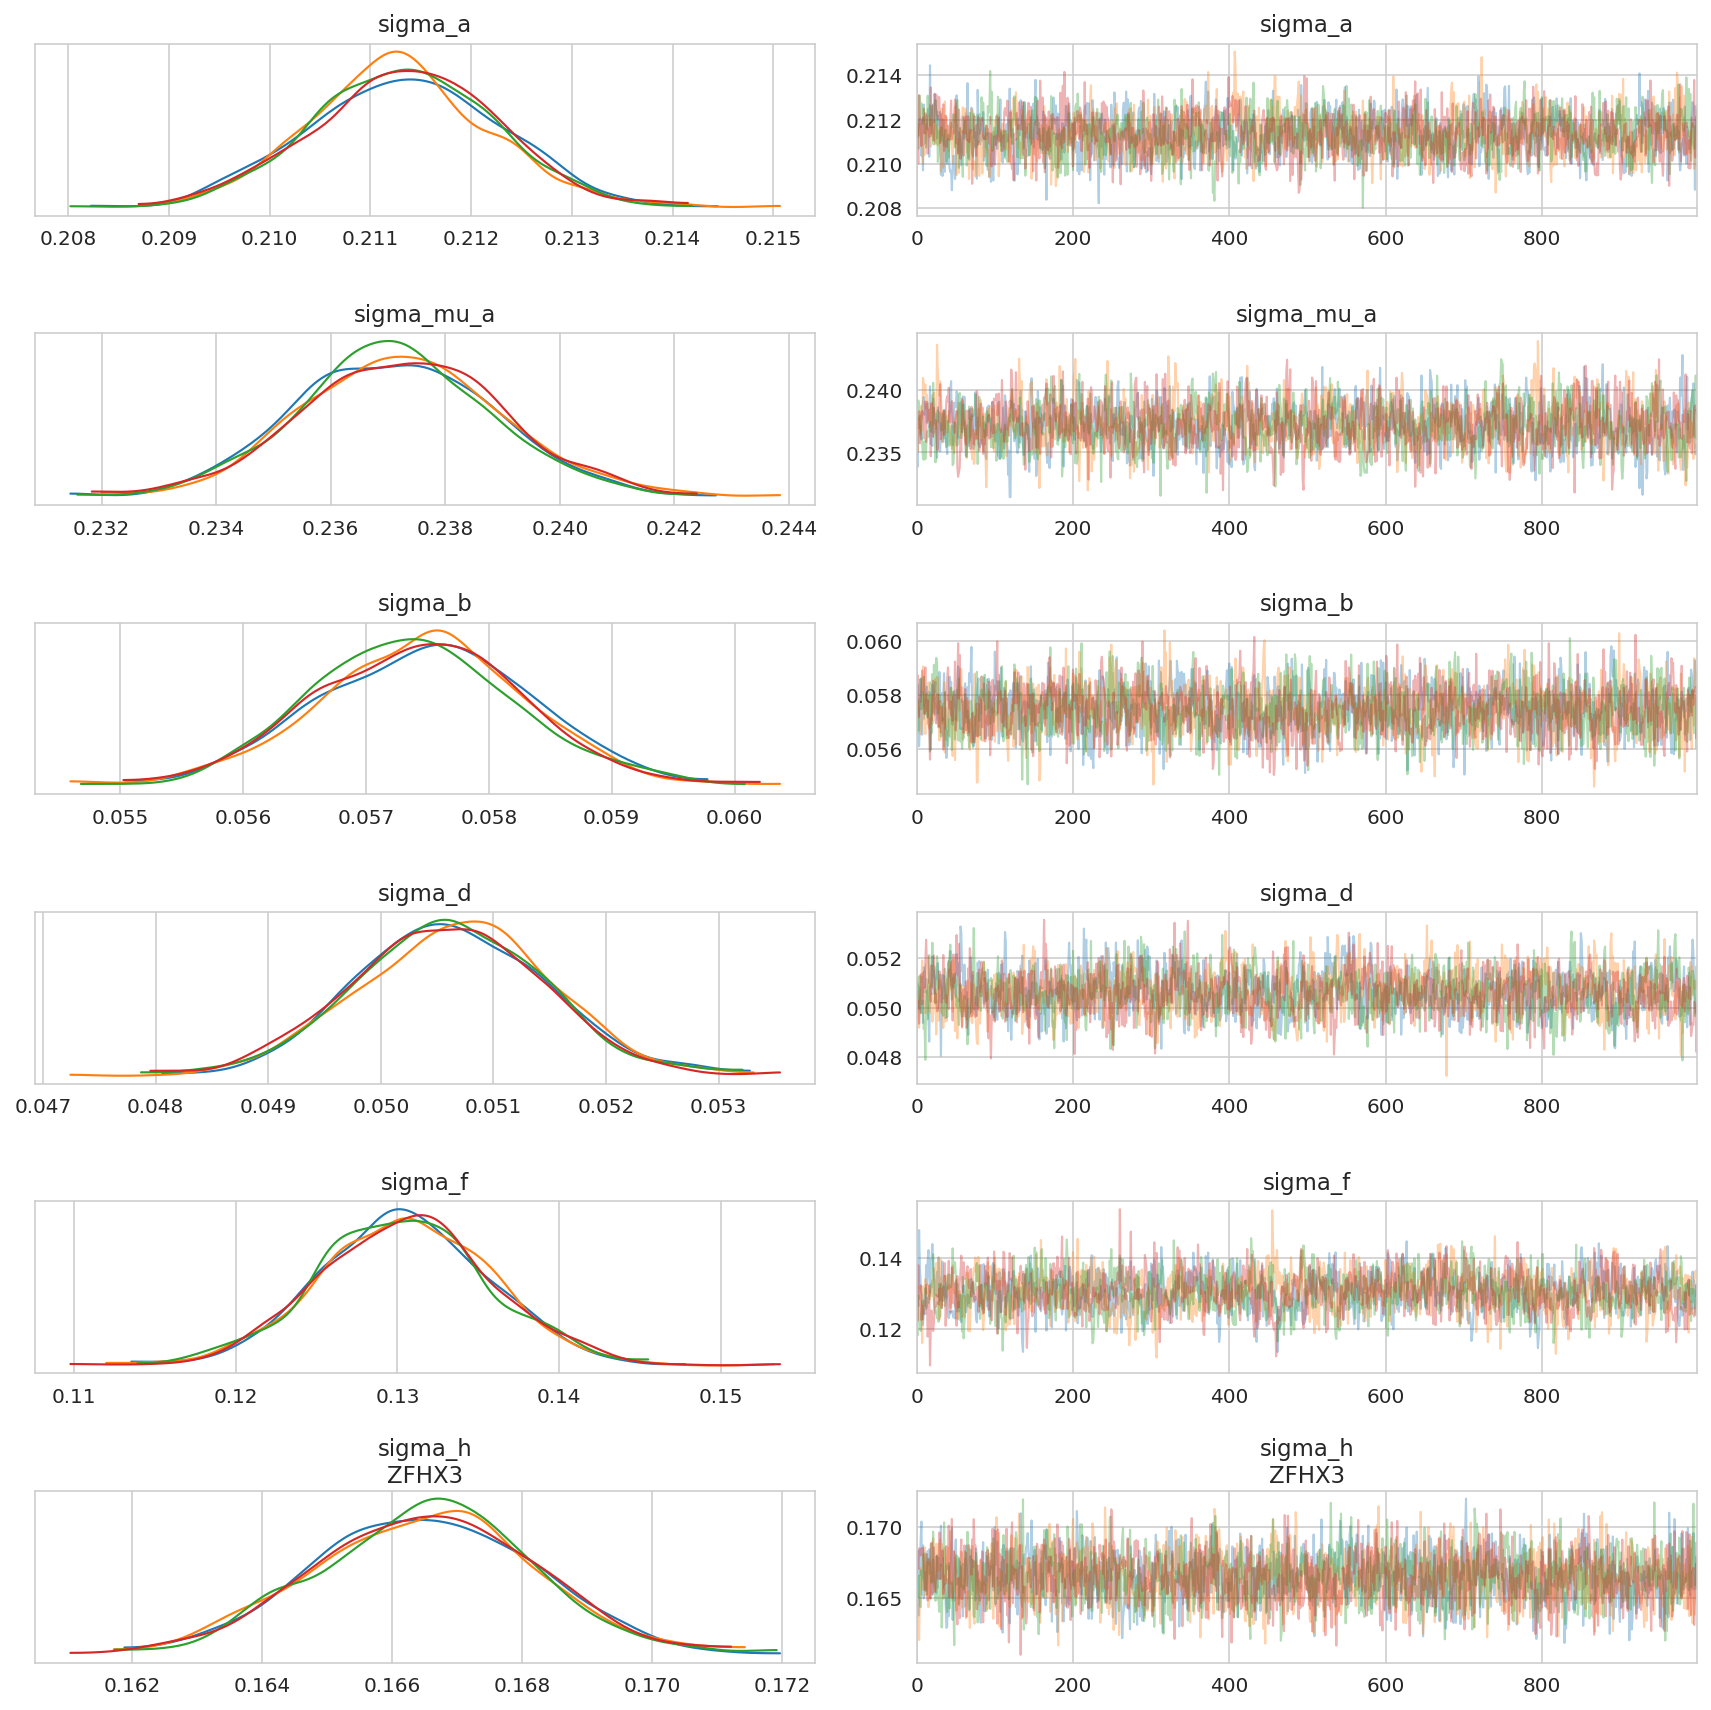

In [19]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

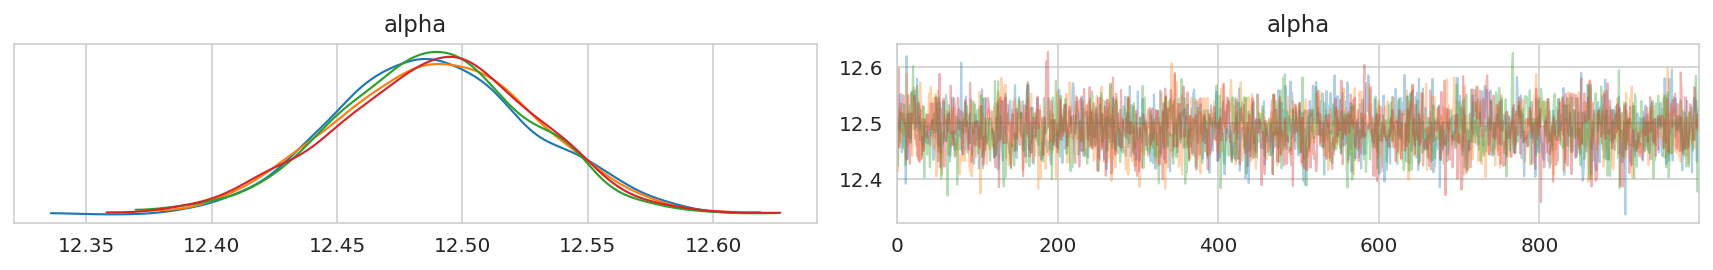

In [20]:
az.plot_trace(trace, var_names=["alpha"], compact=False)
plt.tight_layout()

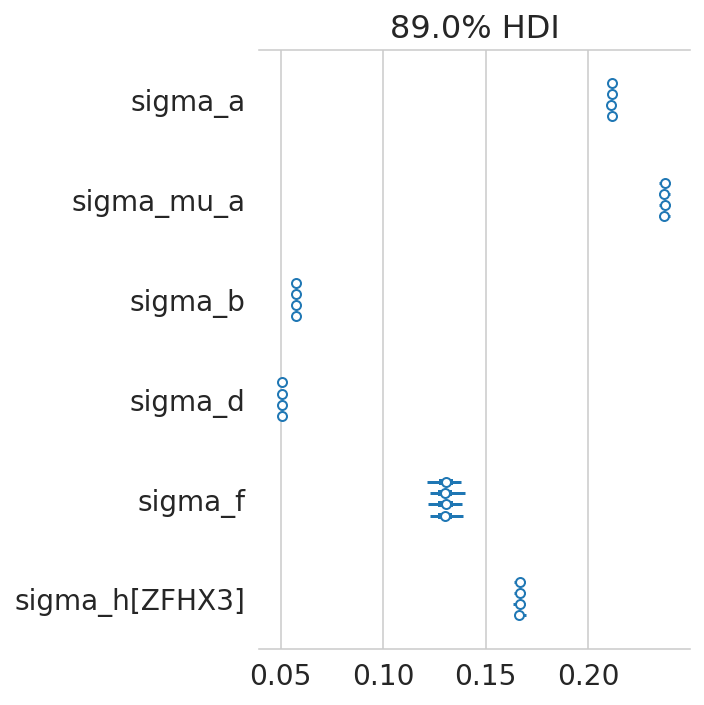

In [21]:
az.plot_forest(
    trace, var_names=["^sigma_*"], filter_vars="regex", combined=False, figsize=(5, 5)
)
plt.tight_layout()

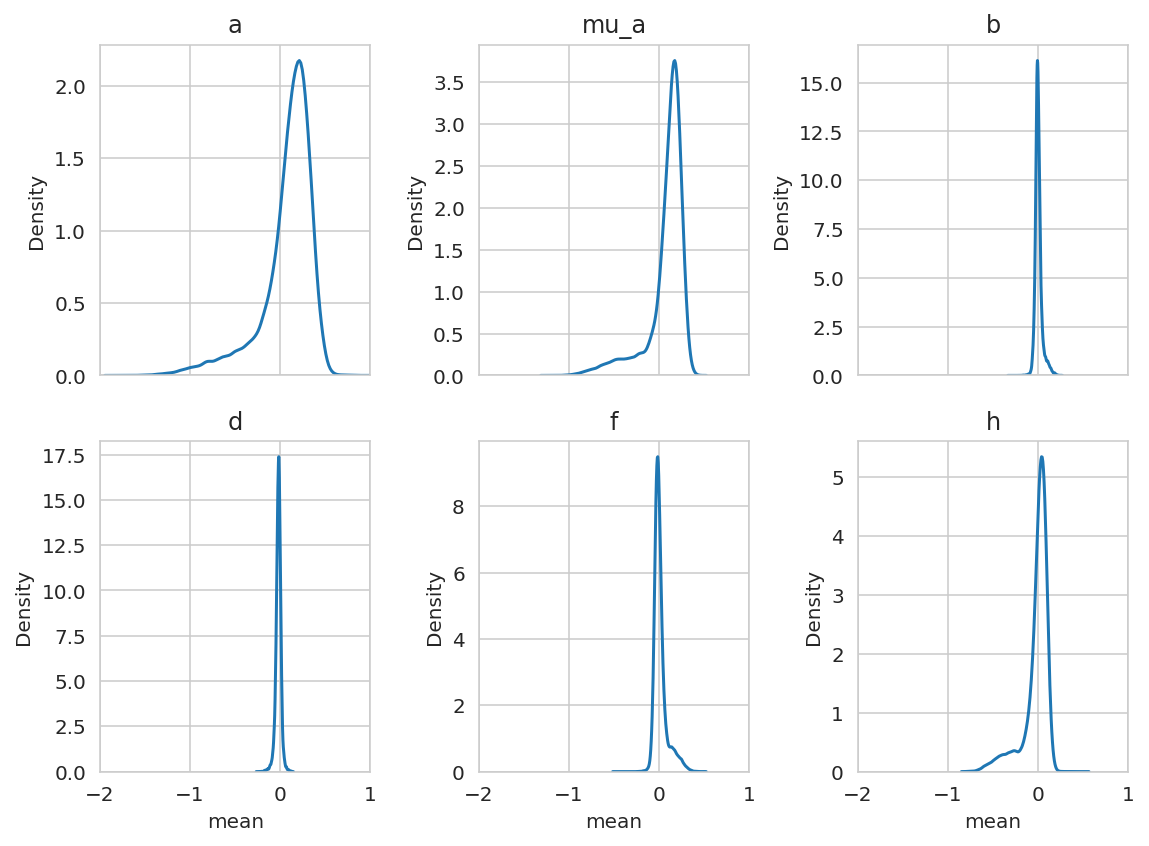

In [22]:
var_names = ["a", "mu_a", "b", "d", "f", "h"]
_, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [23]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [24]:
prostate_post_summary.query("var_name == 'mu_a'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
7784      mu_a[KIF11] -1.223  0.102    -1.378     -1.053      0.002    0.001   
6986      mu_a[HSPE1] -1.052  0.094    -1.194     -0.902      0.002    0.001   
14743     mu_a[SPC24] -1.050  0.101    -1.204     -0.881      0.002    0.001   
12652       mu_a[RAN] -1.034  0.097    -1.194     -0.886      0.002    0.001   
4543       mu_a[EEF2] -1.021  0.095    -1.160     -0.860      0.002    0.001   
4801      mu_a[EPHA2]  0.388  0.094     0.234      0.531      0.002    0.001   
939    mu_a[ARHGAP44]  0.389  0.095     0.234      0.538      0.002    0.001   
2454       mu_a[CCNF]  0.392  0.102     0.226      0.553      0.002    0.001   
6761   mu_a[HLA-DQB1]  0.400  0.104     0.230      0.560      0.002    0.001   
16213      mu_a[TP53]  0.432  0.095     0.285      0.584      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
7784     3369.0    3373.0    1.0     mu_a  
6986     3290.0    3273.0    1.0     mu_a  
14743    3538.0    3394.0    1.0     mu_a  
12652    3159.0    2791.0    1.0     mu_a  
4543     3696.0    3330.0    1.0     mu_a  
4801     3255.0    3248.0    1.0     mu_a  
939      3008.0    2699.0    1.0     mu_a  
2454     3233.0    2905.0    1.0     mu_a  
6761     3204.0    3345.0    1.0     mu_a  
16213    2830.0    3108.0    1.0     mu_a

In [25]:
prostate_post_summary.query("var_name == 'b'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
22901    b[EP300] -0.320  0.042    -0.387     -0.256      0.001      0.0   
34343     b[TP63] -0.179  0.041    -0.242     -0.111      0.000      0.0   
33097    b[STAG2] -0.174  0.039    -0.241     -0.116      0.000      0.0   
22613      b[EBP] -0.167  0.047    -0.240     -0.094      0.000      0.0   
23682    b[FOXA1] -0.165  0.043    -0.234     -0.096      0.000      0.0   
19385  b[ATP6V1F]  0.219  0.042     0.151      0.284      0.000      0.0   
27506   b[MRPL57]  0.224  0.044     0.155      0.295      0.000      0.0   
24315      b[GPI]  0.238  0.044     0.166      0.306      0.000      0.0   
18590    b[AIFM1]  0.250  0.044     0.179      0.319      0.000      0.0   
27883    b[NARS2]  0.253  0.041     0.190      0.322      0.000      0.0   

       ess_bulk  ess_tail  r_hat var_name  
22901    6689.0    3220.0    1.0        b  
34343    9768.0    2628.0    1.0        b  
33097    6678.0    3008.0    1.0        b  
22613    9258.0    2945.0    1.0        b  
23682    8943.0    2996.0    1.0        b  
19385    7922.0    2728.0    1.0        b  
27506    9085.0    2910.0    1.0        b  
24315    8871.0    2920.0    1.0        b  
18590    8653.0    3109.0    1.0        b  
27883    8511.0    2928.0    1.0        b

In [26]:
prostate_post_summary.query("var_name == 'd'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
39173   d[CHMP3] -0.255  0.036    -0.314     -0.201        0.0      0.0   
37444  d[ATP1A1] -0.244  0.041    -0.306     -0.177        0.0      0.0   
52639   d[TRIT1] -0.210  0.039    -0.273     -0.148        0.0      0.0   
44641   d[LONP1] -0.209  0.039    -0.272     -0.147        0.0      0.0   
52954   d[UBE2N] -0.205  0.040    -0.270     -0.142        0.0      0.0   
42785    d[HCCS]  0.121  0.041     0.055      0.187        0.0      0.0   
40991    d[ENO1]  0.123  0.039     0.060      0.185        0.0      0.0   
51555   d[TARS2]  0.123  0.039     0.061      0.183        0.0      0.0   
45607  d[MRPL39]  0.132  0.039     0.072      0.197        0.0      0.0   
40412   d[DMAC1]  0.133  0.042     0.069      0.203        0.0      0.0   

       ess_bulk  ess_tail  r_hat var_name  
39173    7220.0    3235.0    1.0        d  
37444    6787.0    2935.0    1.0        d  
52639    8153.0    3039.0    1.0        d  
44641    9017.0    3223.0    1.0        d  
52954    9047.0    2809.0    1.0        d  
42785    8627.0    3617.0    1.0        d  
40991   10039.0    2785.0    1.0        d  
51555    8559.0    3001.0    1.0        d  
45607    8177.0    2929.0    1.0        d  
40412    8083.0    2764.0    1.0        d

In [27]:
prostate_post_summary.query("var_name == 'h'").sort_values("mean").pipe(head_tail, 5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
77154       h[ELL, ZFHX3] -0.790  0.082    -0.915     -0.658      0.001   
80260     h[KIF11, ZFHX3] -0.786  0.091    -0.936     -0.645      0.001   
88899     h[TRNT1, ZFHX3] -0.764  0.083    -0.896     -0.631      0.001   
80879     h[LONP1, ZFHX3] -0.747  0.088    -0.896     -0.612      0.001   
73736  h[ATP6V1B2, ZFHX3] -0.737  0.079    -0.854     -0.605      0.001   
75408    h[CHMP1B, ZFHX3]  0.223  0.071     0.108      0.337      0.001   
72882      h[AFF4, ZFHX3]  0.244  0.074     0.128      0.365      0.001   
77165      h[ELOA, ZFHX3]  0.264  0.074     0.152      0.387      0.001   
88689      h[TP53, ZFHX3]  0.300  0.074     0.178      0.414      0.001   
77258     h[EP300, ZFHX3]  0.503  0.075     0.380      0.618      0.001   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name  
77154    0.001    5903.0    3196.0    1.0        h  
80260    0.001    6509.0    3319.0    1.0        h  
88899    0.001    6172.0    2944.0    1.0        h  
80879    0.001    5722.0    2960.0    1.0        h  
73736    0.001    6945.0    3549.0    1.0        h  
75408    0.001    6169.0    3154.0    1.0        h  
72882    0.001    6733.0    3381.0    1.0        h  
77165    0.001    7846.0    3480.0    1.0        h  
88689    0.001    5896.0    3500.0    1.0        h  
77258    0.001    4701.0    3269.0    1.0        h

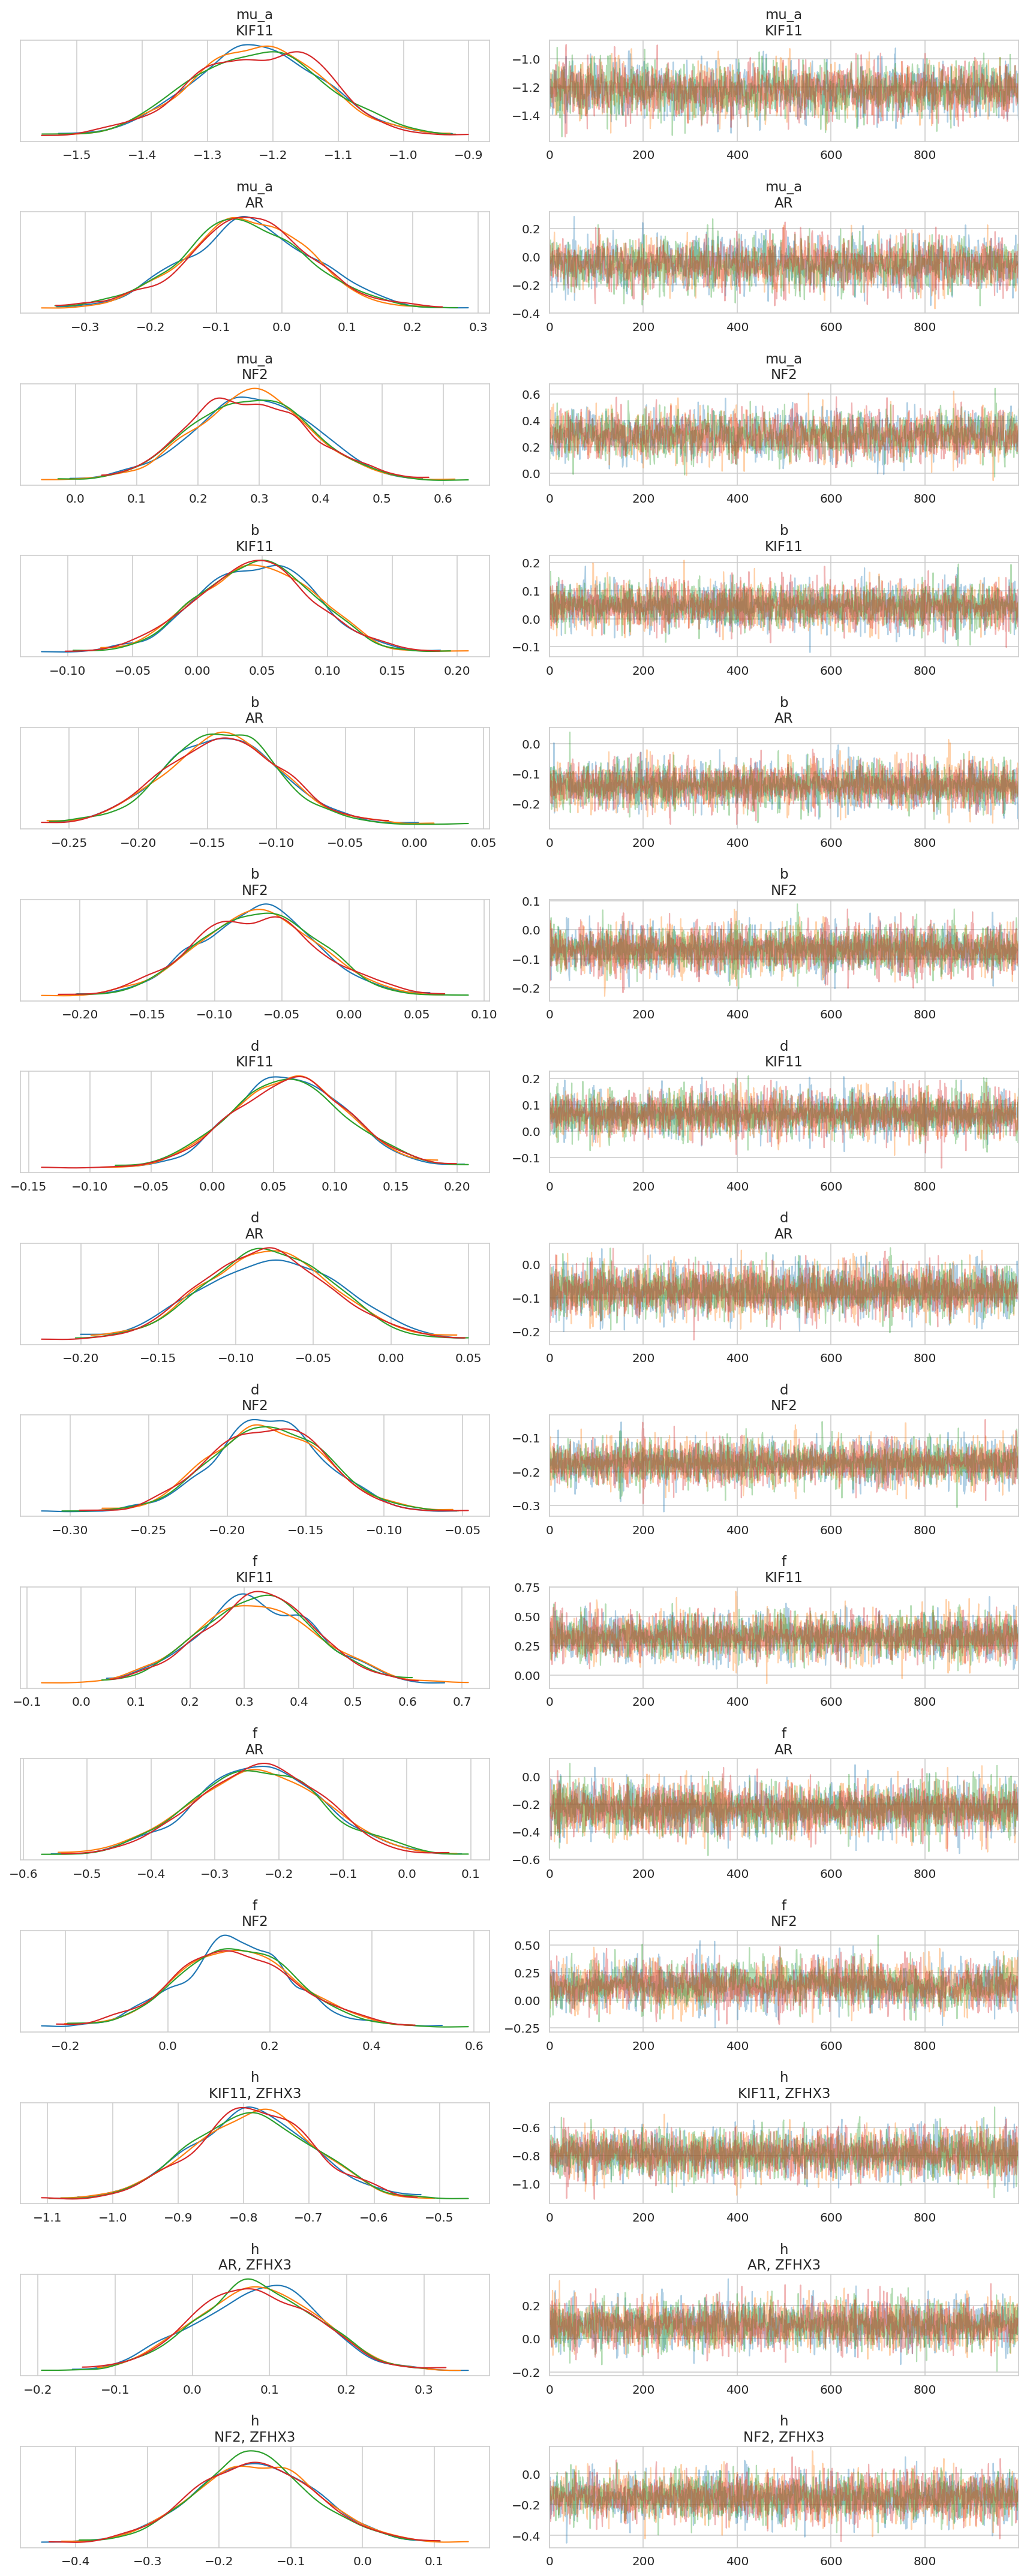

In [28]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace,
    var_names=["mu_a", "b", "d", "f", "h"],
    coords={"gene": example_genes},
    compact=False,
)
plt.tight_layout()
plt.show()

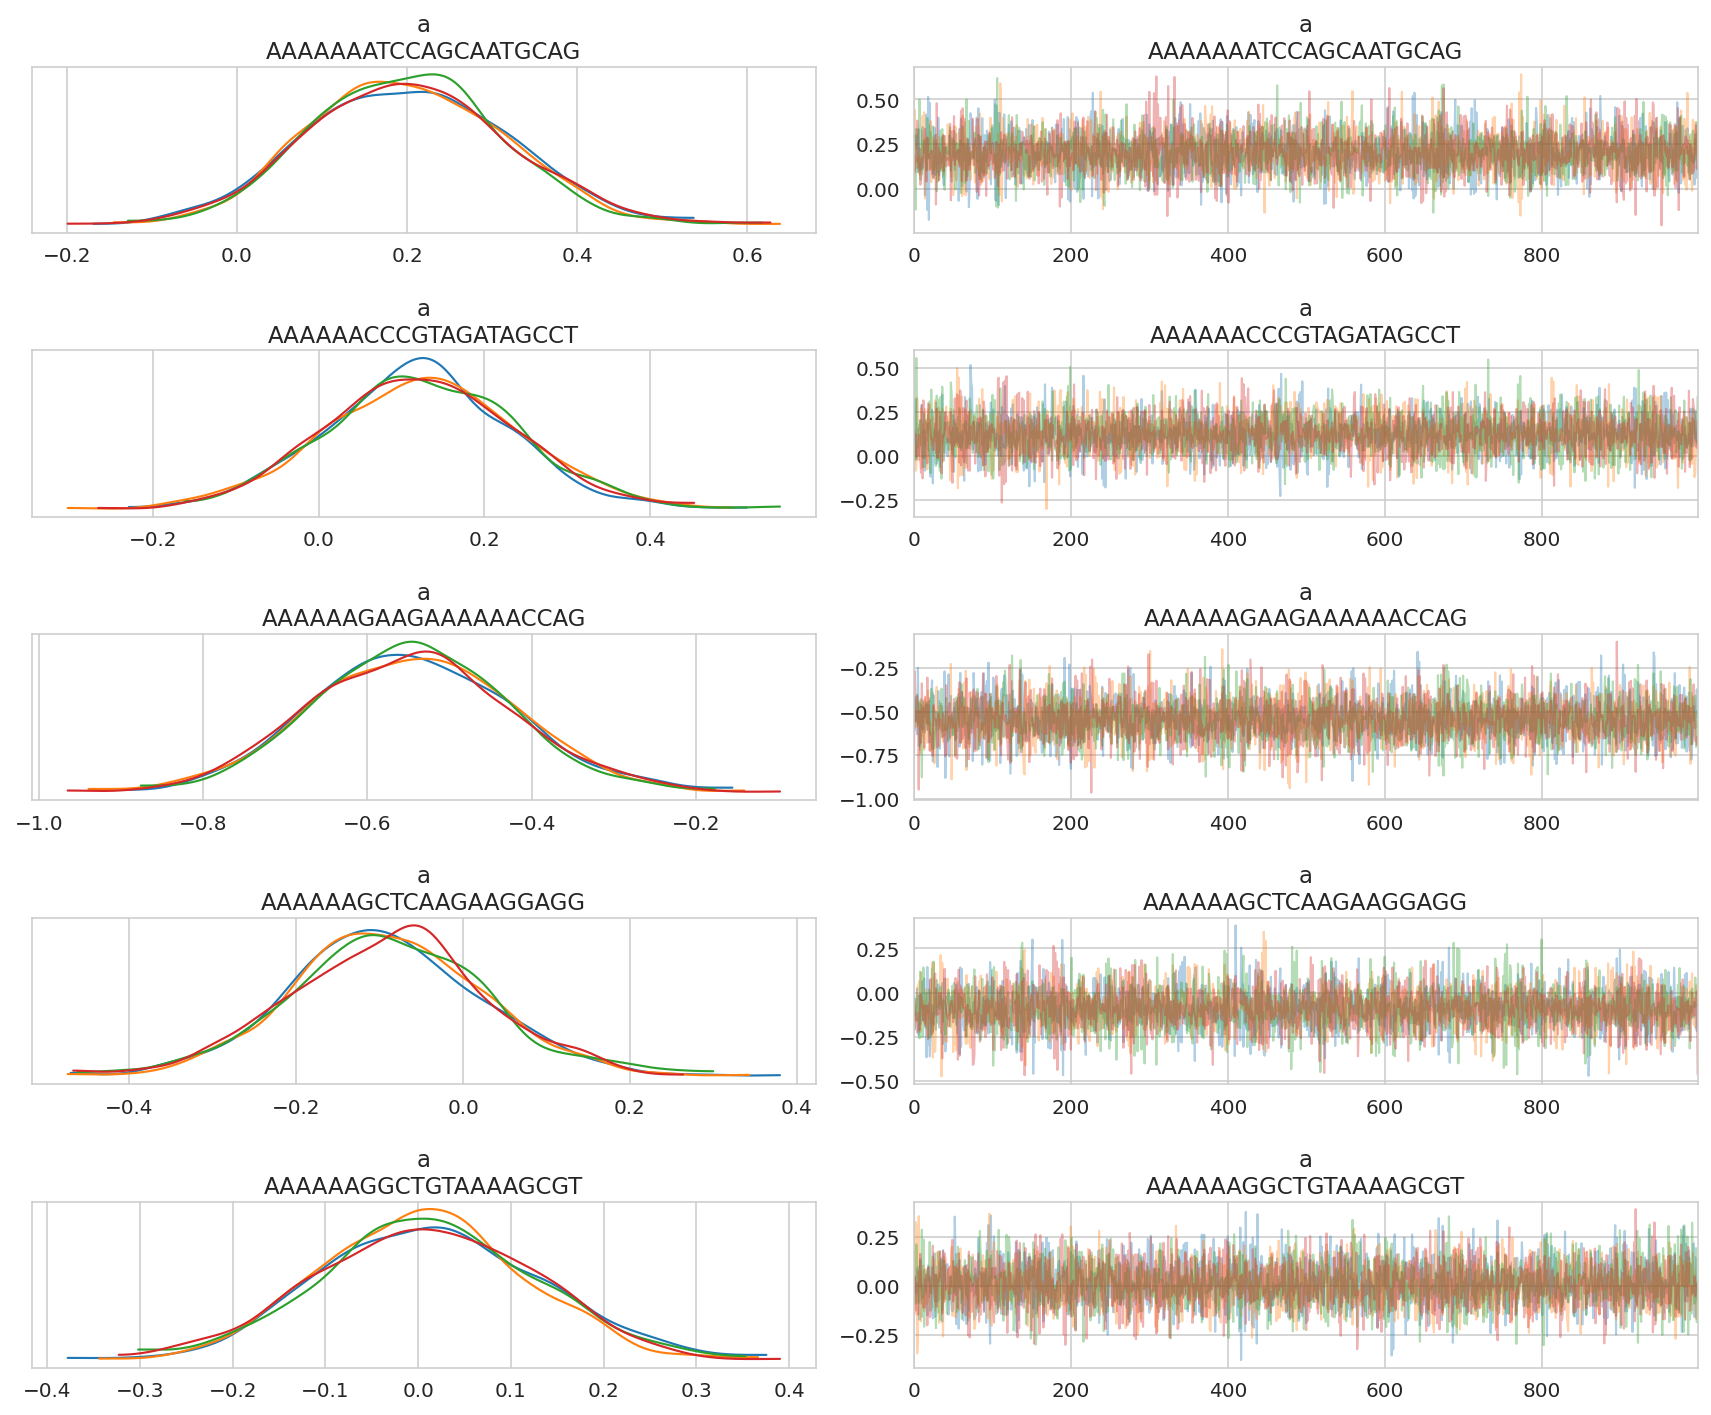

In [29]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

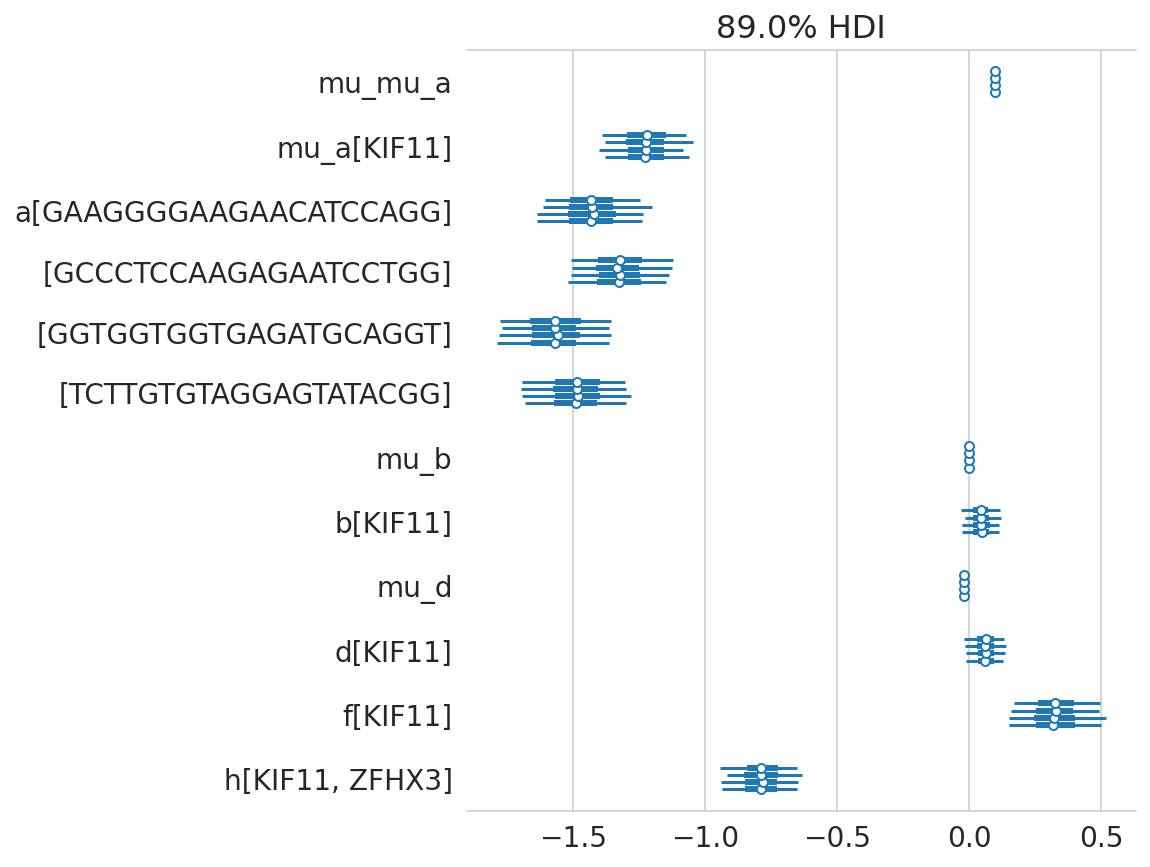

In [30]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=[
        "mu_mu_a",
        "mu_a",
        "a",
        "mu_b",
        "b",
        "mu_d",
        "d",
        # "mu_f",
        "f",
        "h",
    ],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 7),
)
plt.show()

In [31]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
3         sigma_a  0.211  0.001     0.210      0.213        0.0      0.0   
5      sigma_mu_a  0.237  0.002     0.234      0.240        0.0      0.0   
6         sigma_b  0.057  0.001     0.056      0.059        0.0      0.0   
7         sigma_d  0.051  0.001     0.049      0.052        0.0      0.0   
8         sigma_f  0.130  0.005     0.122      0.139        0.0      0.0   
9  sigma_h[ZFHX3]  0.166  0.002     0.164      0.169        0.0      0.0   

   ess_bulk  ess_tail  r_hat    var_name  
3    1459.0    2311.0    1.0     sigma_a  
5    1352.0    2130.0    1.0  sigma_mu_a  
6    1912.0    2862.0    1.0     sigma_b  
7    1238.0    1858.0    1.0     sigma_d  
8     817.0    1766.0    1.0     sigma_f  
9    1605.0    3115.0    1.0     sigma_h

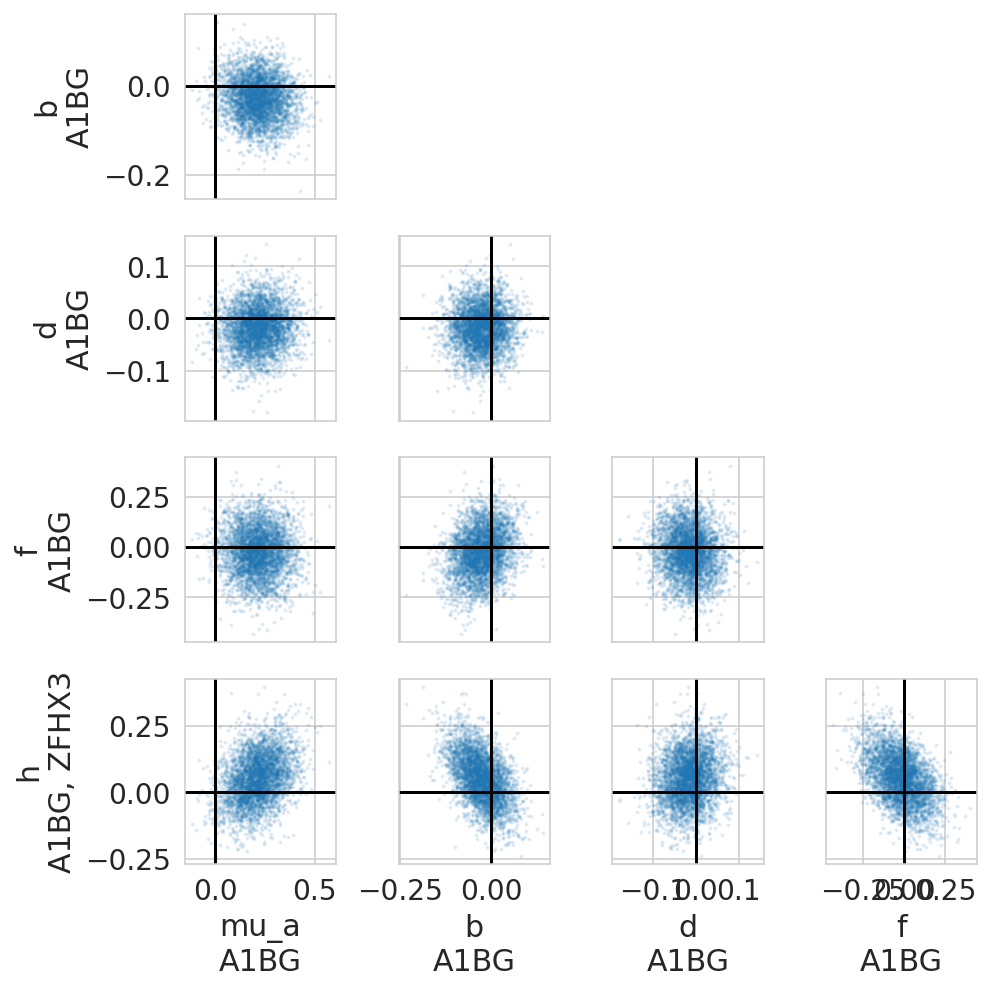

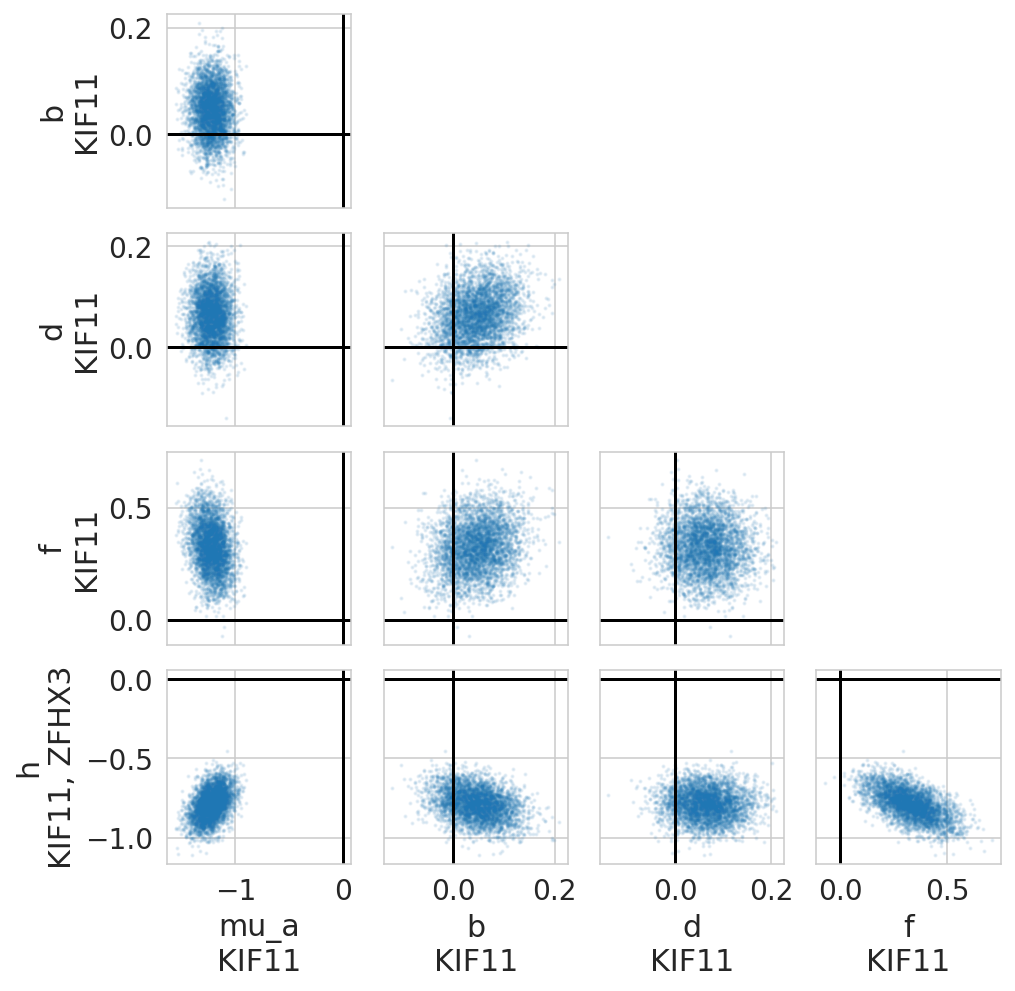

In [32]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d", "f", "h"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.1, "markersize": 2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

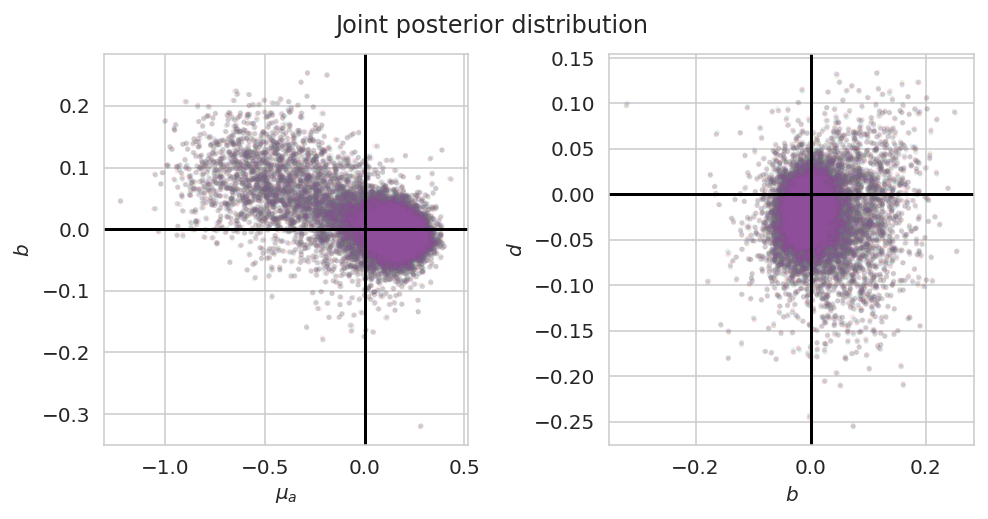

In [33]:
def _get_average_per_chain(trace: az.InferenceData, var_name: str) -> pd.DataFrame:
    return (
        trace.posterior[var_name]
        .mean(axis=(1))
        .to_dataframe()
        .reset_index()
        .astype({"chain": str})
    )


mu_a_post_avg = _get_average_per_chain(trace, "mu_a")
b_post_avg = _get_average_per_chain(trace, "b")
d_post_avg = _get_average_per_chain(trace, "d")

gene_post_avg = mu_a_post_avg.merge(b_post_avg, on=["chain", "gene"]).merge(
    d_post_avg, on=["chain", "gene"]
)


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(
    data=gene_post_avg,
    x="mu_a",
    y="b",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(
    data=gene_post_avg,
    x="b",
    y="d",
    hue="chain",
    palette="Set1",
    alpha=0.1,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")
    ax.get_legend().remove()


fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [34]:
genes_var_names = ["mu_a", "b", "d", "f"]
genes_var_names += [f"h[{g}]" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
    .assign(
        p1=lambda d: pd.Categorical(d["p1"], categories=d["p1"].unique(), ordered=True)
    )
    .assign(
        p2=lambda d: pd.Categorical(
            d["p2"], categories=d["p1"].cat.categories, ordered=True
        )
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0   
genes_chol_cov_corr[0, 1] -0.383  0.014    -0.404     -0.361   0   1   
genes_chol_cov_corr[0, 2]  0.107  0.016     0.083      0.134   0   2   
genes_chol_cov_corr[0, 3] -0.483  0.035    -0.537     -0.428   0   3   
genes_chol_cov_corr[0, 4]  0.832  0.010     0.817      0.848   0   4   
genes_chol_cov_corr[1, 0] -0.383  0.014    -0.404     -0.361   1   0   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1   
genes_chol_cov_corr[1, 2] -0.020  0.021    -0.055      0.012   1   2   
genes_chol_cov_corr[1, 3]  0.375  0.052     0.289      0.456   1   3   
genes_chol_cov_corr[1, 4] -0.539  0.016    -0.564     -0.514   1   4   
genes_chol_cov_corr[2, 0]  0.107  0.016     0.083      0.134   2   0   
genes_chol_cov_corr[2, 1] -0.020  0.021    -0.055      0.012   2   1   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2   
genes_chol_cov_corr[2, 3] -0.104  0.048    -0.181     -0.030   2   3   
genes_chol_cov_corr[2, 4]  0.129  0.017     0.101      0.154   2   4   
genes_chol_cov_corr[3, 0] -0.483  0.035    -0.537     -0.428   3   0   
genes_chol_cov_corr[3, 1]  0.375  0.052     0.289      0.456   3   1   
genes_chol_cov_corr[3, 2] -0.104  0.048    -0.181     -0.030   3   2   
genes_chol_cov_corr[3, 3]  1.000  0.000     1.000      1.000   3   3   
genes_chol_cov_corr[3, 4] -0.669  0.028    -0.714     -0.624   3   4   
genes_chol_cov_corr[4, 0]  0.832  0.010     0.817      0.848   4   0   
genes_chol_cov_corr[4, 1] -0.539  0.016    -0.564     -0.514   4   1   
genes_chol_cov_corr[4, 2]  0.129  0.017     0.101      0.154   4   2   
genes_chol_cov_corr[4, 3] -0.669  0.028    -0.714     -0.624   4   3   
genes_chol_cov_corr[4, 4]  1.000  0.000     1.000      1.000   4   4   

                                 p1        p2  
genes_chol_cov_corr[0, 0]      mu_a      mu_a  
genes_chol_cov_corr[0, 1]      mu_a         b  
genes_chol_cov_corr[0, 2]      mu_a         d  
genes_chol_cov_corr[0, 3]      mu_a         f  
genes_chol_cov_corr[0, 4]      mu_a  h[ZFHX3]  
genes_chol_cov_corr[1, 0]         b      mu_a  
genes_chol_cov_corr[1, 1]         b         b  
genes_chol_cov_corr[1, 2]         b         d  
genes_chol_cov_corr[1, 3]         b         f  
genes_chol_cov_corr[1, 4]         b  h[ZFHX3]  
genes_chol_cov_corr[2, 0]         d      mu_a  
genes_chol_cov_corr[2, 1]         d         b  
genes_chol_cov_corr[2, 2]         d         d  
genes_chol_cov_corr[2, 3]         d         f  
genes_chol_cov_corr[2, 4]         d  h[ZFHX3]  
genes_chol_cov_corr[3, 0]         f      mu_a  
genes_chol_cov_corr[3, 1]         f         b  
genes_chol_cov_corr[3, 2]         f         d  
genes_chol_cov_corr[3, 3]         f         f  
genes_chol_cov_corr[3, 4]         f  h[ZFHX3]  
genes_chol_cov_corr[4, 0]  h[ZFHX3]      mu_a  
genes_chol_cov_corr[4, 1]  h[ZFHX3]         b  
genes_chol_cov_corr[4, 2]  h[ZFHX3]         d  
genes_chol_cov_corr[4, 3]  h[ZFHX3]         f  
genes_chol_cov_corr[4, 4]  h[ZFHX3]  h[ZFHX3]

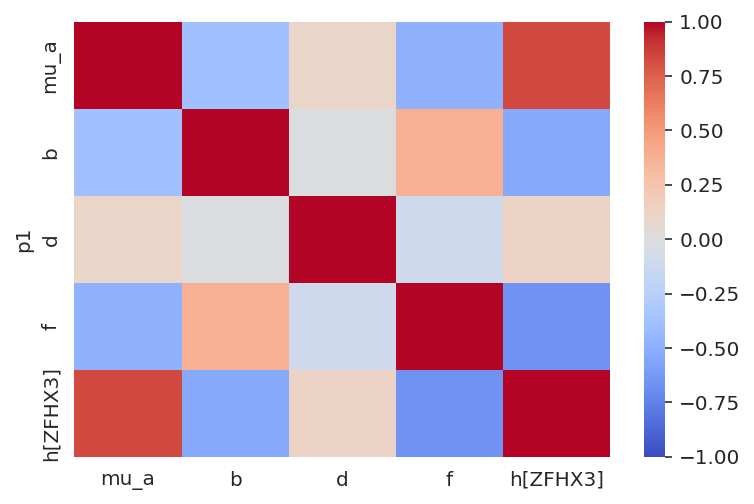

In [35]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

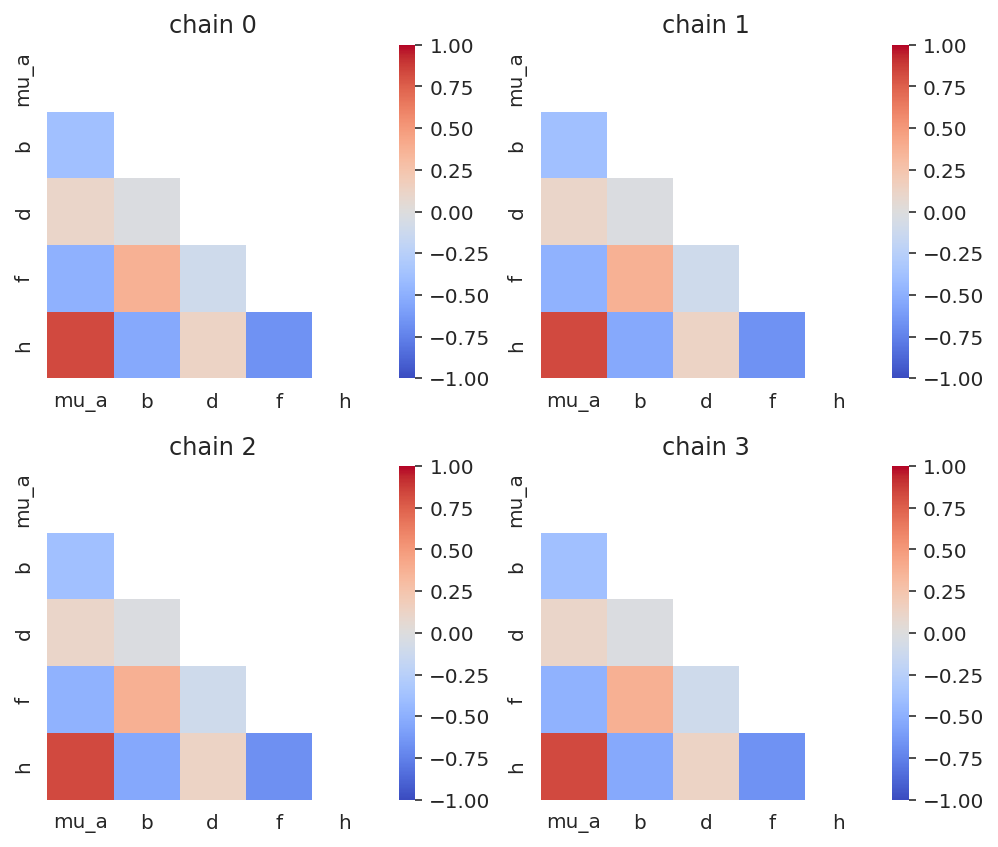

In [36]:
genes_var_corr = trace.posterior["genes_chol_cov_corr"].mean(axis=(1))
genes_var_names = ["mu_a", "b", "d", "f", "h"]
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

for c, ax in enumerate(axes.flatten()):
    data = genes_var_corr[c, :, :].values.copy()
    np.fill_diagonal(data, np.nan)
    data[~np.tril(data).astype(bool)] = np.nan
    sns.heatmap(data, vmin=-1, vmax=1, cmap="coolwarm", ax=ax)
    ax.set_xticklabels(genes_var_names)
    ax.set_yticklabels(genes_var_names)
    ax.set_title(f"chain {c}")

fig.tight_layout()
plt.show()

In [37]:
cancer_genes = trace.posterior.coords["cancer_gene"].values.tolist()
cancer_gene_mutants = (
    valid_prostate_data.filter_column_isin("hugo_symbol", cancer_genes)[
        ["hugo_symbol", "depmap_id", "is_mutated"]
    ]
    .drop_duplicates()
    .assign(is_mutated=lambda d: d["is_mutated"].map({True: "X", False: ""}))
    .pivot_wider("depmap_id", names_from="hugo_symbol", values_from="is_mutated")
    .set_index("depmap_id")
)
cancer_gene_mutants

ZFHX3
depmap_id       
ACH-000115      
ACH-000977     X
ACH-001453      
ACH-001627     X
ACH-001648

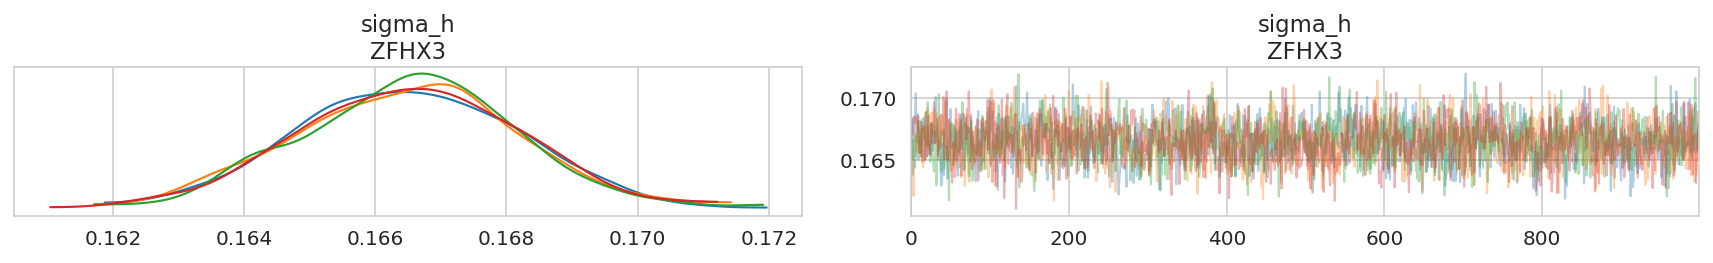

In [38]:
az.plot_trace(trace, var_names=["sigma_h"], compact=False)
plt.tight_layout()
plt.show()

In [39]:
h_post_summary = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["hugo_symbol", "cancer_gene"],
        col="parameter",
    )
)
h_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     h[A1BG, ZFHX3]  0.053  0.088    -0.092      0.185      0.001    0.001   
1     h[A1CF, ZFHX3]  0.104  0.076    -0.021      0.219      0.001    0.001   
2      h[A2M, ZFHX3]  0.096  0.082    -0.034      0.228      0.001    0.001   
3    h[A2ML1, ZFHX3] -0.030  0.077    -0.152      0.092      0.001    0.001   
4  h[A3GALT2, ZFHX3]  0.004  0.074    -0.114      0.121      0.001    0.001   

   ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
0    6166.0    3078.0    1.0        h        A1BG       ZFHX3  
1    6297.0    2980.0    1.0        h        A1CF       ZFHX3  
2    5895.0    3132.0    1.0        h         A2M       ZFHX3  
3    6900.0    3153.0    1.0        h       A2ML1       ZFHX3  
4    5902.0    3093.0    1.0        h     A3GALT2       ZFHX3

In [40]:
h_post_summary.sort_values("mean").pipe(head_tail, n=5)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
4668        h[ELL, ZFHX3] -0.790  0.082    -0.915     -0.658      0.001   
7774      h[KIF11, ZFHX3] -0.786  0.091    -0.936     -0.645      0.001   
16413     h[TRNT1, ZFHX3] -0.764  0.083    -0.896     -0.631      0.001   
8393      h[LONP1, ZFHX3] -0.747  0.088    -0.896     -0.612      0.001   
1250   h[ATP6V1B2, ZFHX3] -0.737  0.079    -0.854     -0.605      0.001   
2922     h[CHMP1B, ZFHX3]  0.223  0.071     0.108      0.337      0.001   
396        h[AFF4, ZFHX3]  0.244  0.074     0.128      0.365      0.001   
4679       h[ELOA, ZFHX3]  0.264  0.074     0.152      0.387      0.001   
16203      h[TP53, ZFHX3]  0.300  0.074     0.178      0.414      0.001   
4772      h[EP300, ZFHX3]  0.503  0.075     0.380      0.618      0.001   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name hugo_symbol cancer_gene  
4668     0.001    5903.0    3196.0    1.0        h         ELL       ZFHX3  
7774     0.001    6509.0    3319.0    1.0        h       KIF11       ZFHX3  
16413    0.001    6172.0    2944.0    1.0        h       TRNT1       ZFHX3  
8393     0.001    5722.0    2960.0    1.0        h       LONP1       ZFHX3  
1250     0.001    6945.0    3549.0    1.0        h    ATP6V1B2       ZFHX3  
2922     0.001    6169.0    3154.0    1.0        h      CHMP1B       ZFHX3  
396      0.001    6733.0    3381.0    1.0        h        AFF4       ZFHX3  
4679     0.001    7846.0    3480.0    1.0        h        ELOA       ZFHX3  
16203    0.001    5896.0    3500.0    1.0        h        TP53       ZFHX3  
4772     0.001    4701.0    3269.0    1.0        h       EP300       ZFHX3

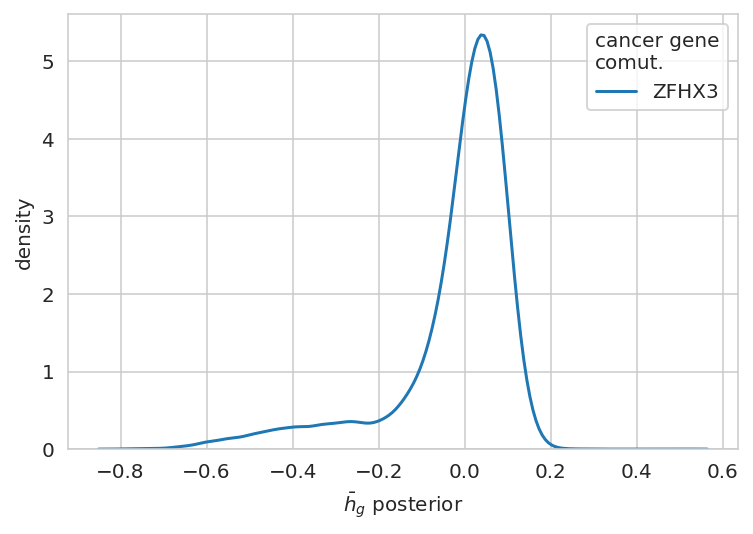

In [41]:
ax = sns.kdeplot(data=h_post_summary, x="mean", hue="cancer_gene")
ax.set_xlabel(r"$\bar{h}_g$ posterior")
ax.set_ylabel("density")
ax.get_legend().set_title("cancer gene\ncomut.")
plt.show()

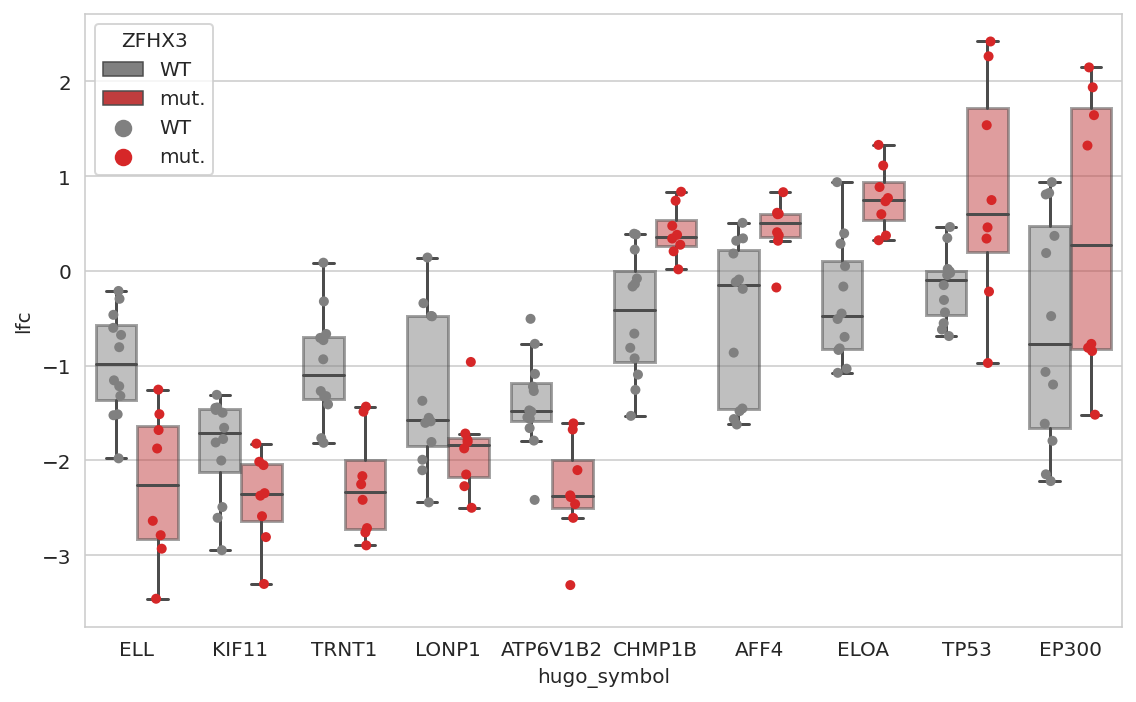

In [42]:
fig, axes = plt.subplots(
    len(cancer_genes), 1, squeeze=False, figsize=(8, len(cancer_genes) * 5)
)
for ax, cg in zip(axes.flatten(), cancer_genes):
    h_hits = (
        h_post_summary.filter_column_isin("cancer_gene", [cg])
        .sort_values("mean")
        .pipe(head_tail, n=5)["hugo_symbol"]
        .tolist()
    )

    h_hits_data = (
        valid_prostate_data.filter_column_isin("hugo_symbol", h_hits)
        .merge(cancer_gene_mutants.reset_index(), on="depmap_id")
        .reset_index()
        .astype({"hugo_symbol": str})
        .assign(
            hugo_symbol=lambda d: pd.Categorical(d["hugo_symbol"], categories=h_hits),
            _cg_mut=lambda d: d[cg].map({"X": "mut.", "": "WT"}),
        )
    )
    mut_pal = {"mut.": "tab:red", "WT": "gray"}
    sns.boxplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        palette=mut_pal,
        ax=ax,
        showfliers=False,
        boxprops={"alpha": 0.5},
    )
    sns.stripplot(
        data=h_hits_data,
        x="hugo_symbol",
        y="lfc",
        hue="_cg_mut",
        dodge=True,
        palette=mut_pal,
        ax=ax,
    )
    ax.get_legend().set_title(cg)

plt.tight_layout()
plt.show()

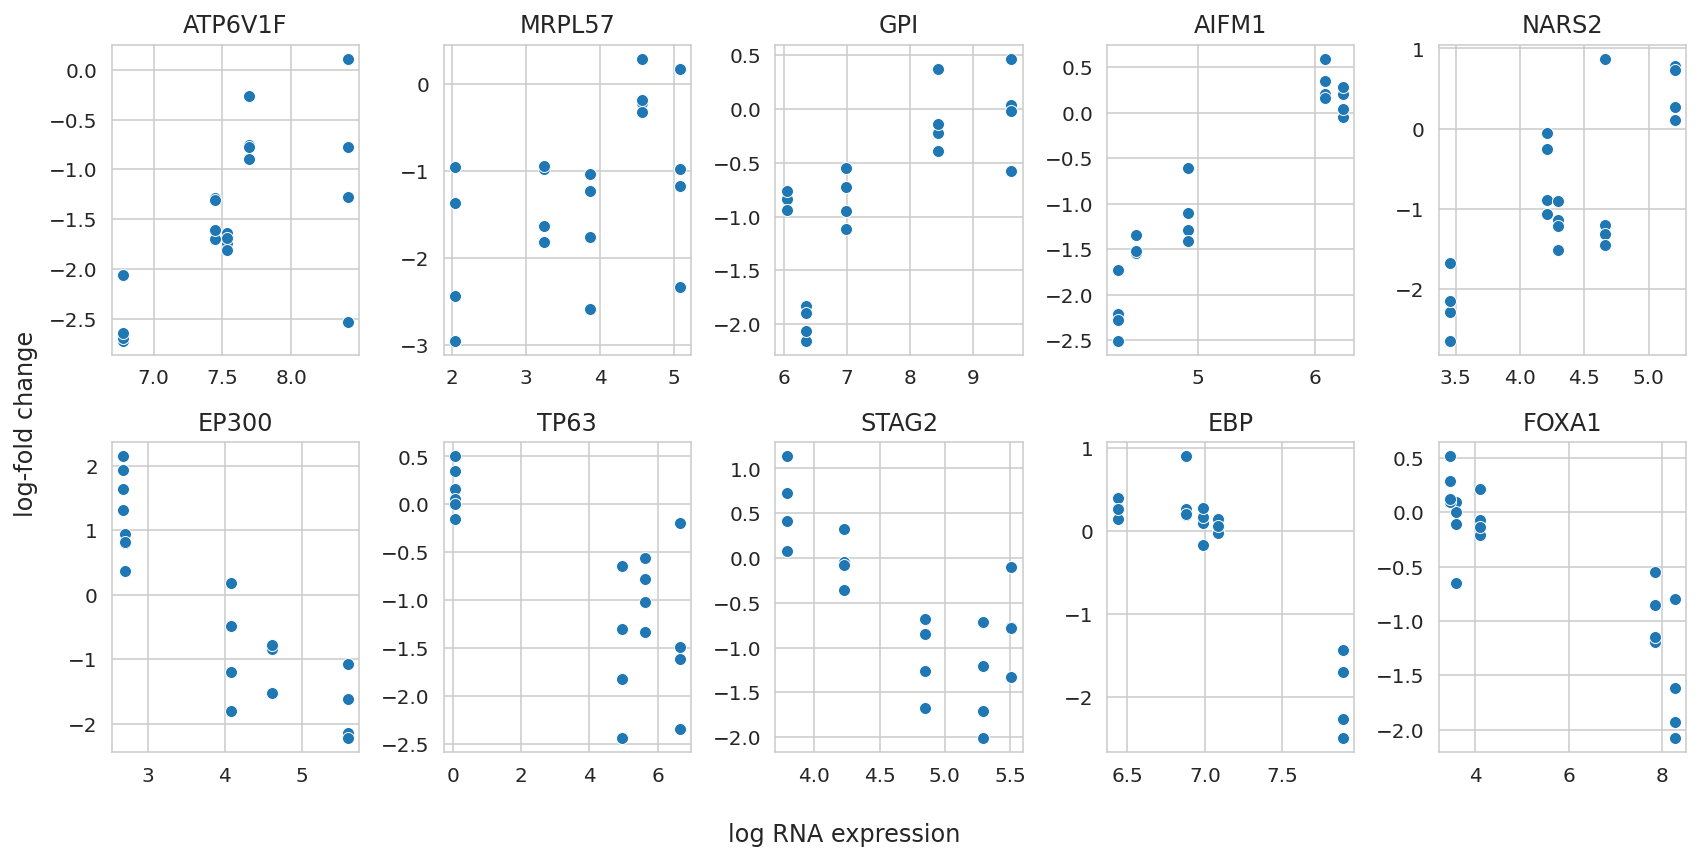

In [43]:
top_n = 5
top_b_hits = (
    prostate_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_b = top_b_hits["hugo_symbol"][:top_n].values
positive_b = top_b_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_b, negative_b]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="rna_expr", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("log RNA expression")
fig.supylabel("log-fold change")

fig.tight_layout()
plt.show()

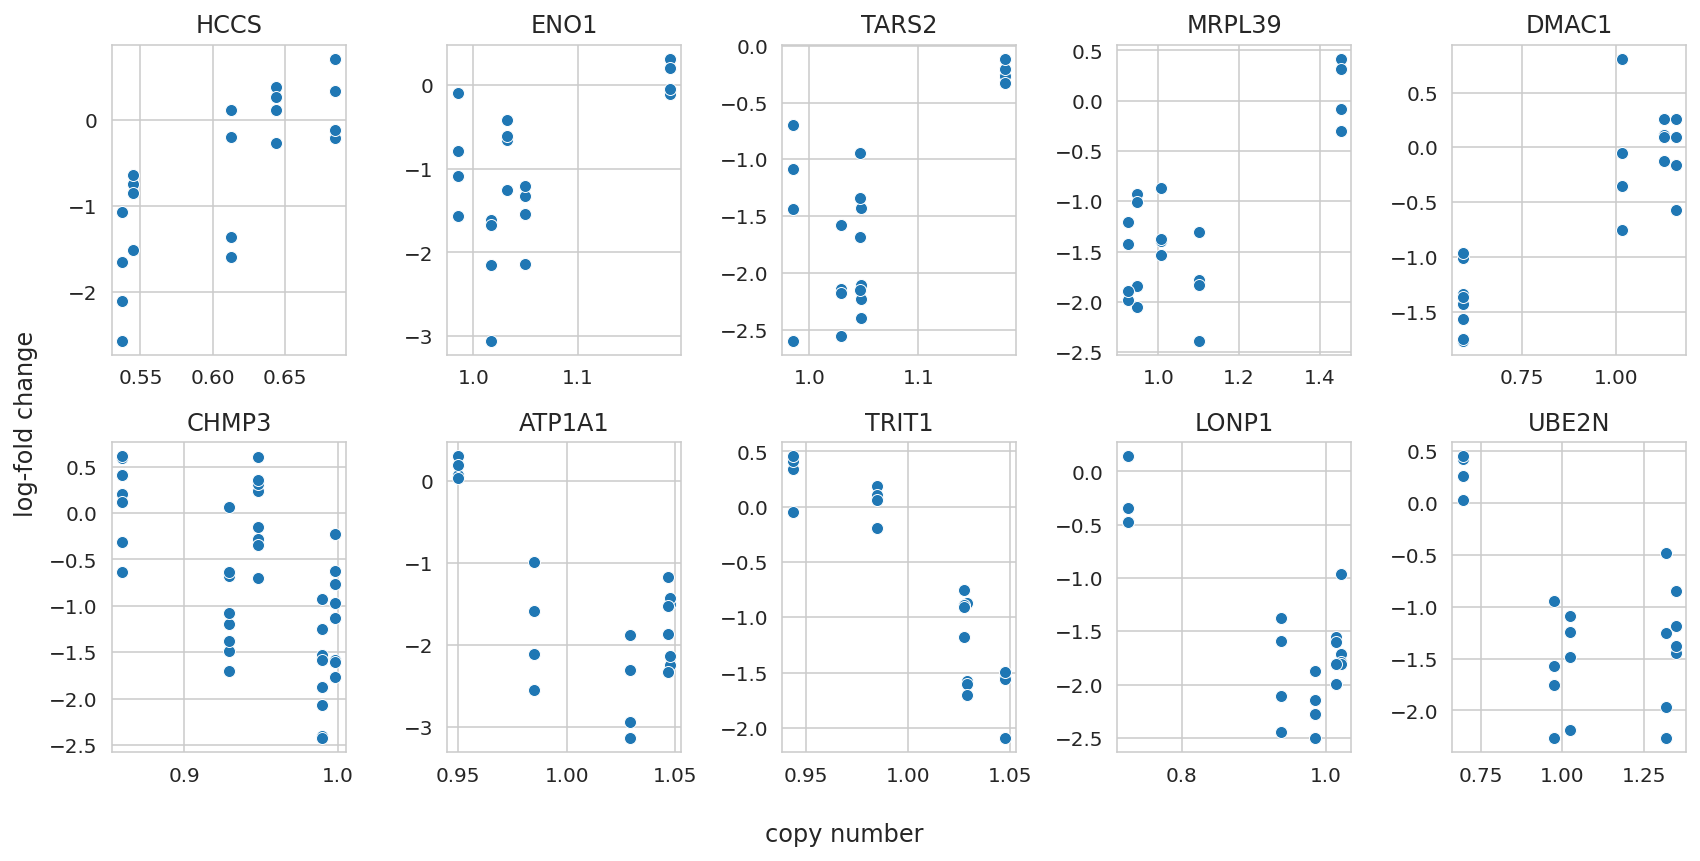

In [44]:
top_n = 5
top_d_hits = (
    prostate_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
    .pipe(head_tail, n=top_n)
)

negative_d = top_d_hits["hugo_symbol"][:top_n].values
positive_d = top_d_hits["hugo_symbol"][top_n:].values


fig, axes = plt.subplots(2, top_n, figsize=(12, 6))

for i, genes in enumerate([positive_d, negative_d]):
    for j, gene in enumerate(genes):
        ax = axes[i, j]
        ax.set_title(gene)
        obs_data = prostate_data.query(f"hugo_symbol == '{gene}'")
        sns.scatterplot(data=obs_data, x="copy_number", y="lfc", ax=ax)
        ax.set_xlabel(None)
        ax.set_ylabel(None)


fig.supxlabel("copy number")
fig.supylabel("log-fold change")
fig.tight_layout()
plt.show()

## PPC

In [45]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

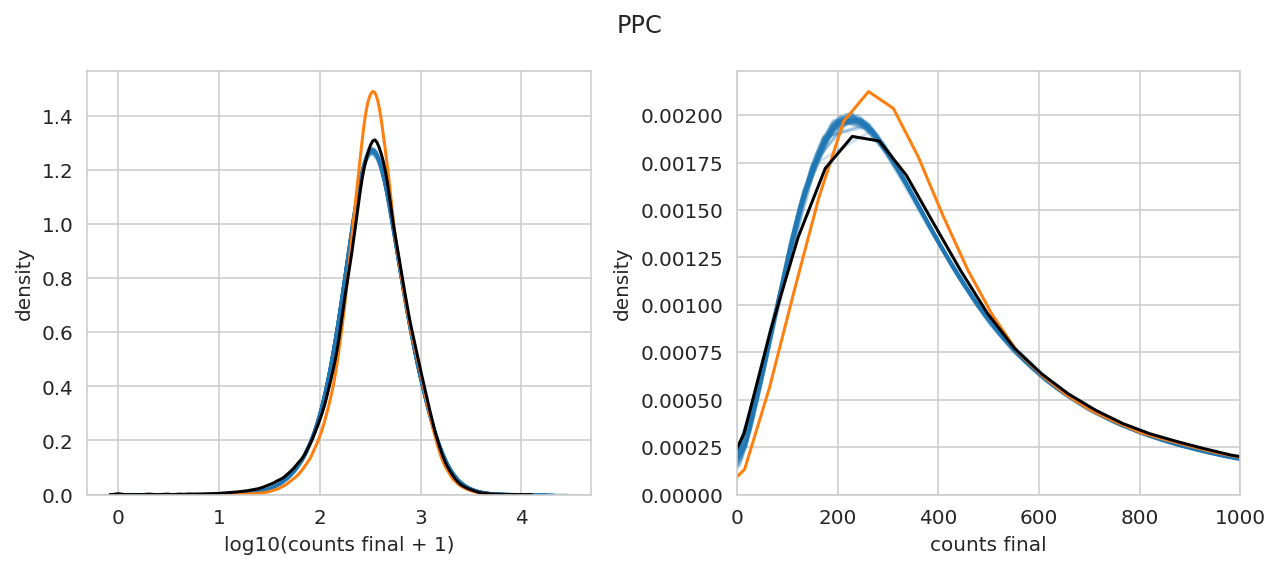

In [46]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [47]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 6.32 minutes


In [48]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-29

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.71.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: simplify

pandas    : 1.4.3
numpy     : 1.22.4
qnorm     : 0.8.1
arviz     : 0.12.1
matplotlib: 3.5.2
seaborn   : 0.11.2

